In [ ]:
!pip install requests beautifulsoup4 pandas openpyxl selenium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.2/499.2 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.15.0
    Uninstalling typing_extensions-4.15.0:
      Successfully uninstalled typing_extensions-4.15.0


In [ ]:
import pandas as pd

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import pandas as pd
import time
import re

def extract_service_from_post_top(post_top):
    """
    Возвращает строку услуги (например "акушер-гинеколог", "онкология", "лечение кариеса")
    или None, если не найдено.
    """
    if not post_top:
        return None

    for a in post_top.find_all("a"):
        a_text = a.get_text(" ", strip=True).lower()
        if "отзыв" in a_text:
            m = re.search(r"отзыв(?:\s+о|об)?\s+(.+)", a_text)
            if m:
                serv = m.group(1).strip()
                serv = re.split(r"\s+в\s+москве.*|\s+в\s+городе.*|\s+в\s+г\..*", serv)[0].strip()
                return normalize_service(serv)

    txt = post_top.get_text(" ", strip=True).lower()

    patterns = [
        r"оставил(?:[^\w]|).*?отзыв(?:\s+о|об)?\s+(.+?)(?:\s+у\s+врача|\s+при\s+посещении|\s+при\s+|,|\.|$)",
        r"отзыв(?:\s+о|об)?\s+(.+?)(?:\s+у\s+врача|\s+при\s+посещении|\s+при\s+|,|\.|$)",
    ]

    for pat in patterns:
        m = re.search(pat, txt)
        if m:
            serv = m.group(1).strip()
            serv = re.split(r"\s+у\s+врача|\s+при\s+посещении|\s+в\s+москве.*|,|\.|$", serv)[0].strip()
            return normalize_service(serv)

    if re.search(r"оставил(?:[^\w]|).*?отзыв(?:[^\w]|).*?у\s+врача", txt):
        return None

    return None


def normalize_service(service: str) -> str:
    if not service:
        return None
    service = re.sub(r"\b(при[её]м|приеме|осмотр|консультаци[яи]|первичный)\b", "", service)

    service = re.sub(r"\s{2,}", " ", service).strip()
    return service if service else None

url = "https://like.doctor/moskva/otzyvy"

options = Options()
options.add_argument("--headless")
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")

driver = webdriver.Chrome(options=options)
driver.get(url)

SCROLL_PAUSE = 2
reviews_count = 0
target_count = 3000

print("Начинаем скроллинг страницы...")

while True:
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(SCROLL_PAUSE)

    soup = BeautifulSoup(driver.page_source, "html.parser")
    reviews = soup.select(".wrapper-comments.postblock")

    if len(reviews) > reviews_count:
        reviews_count = len(reviews)
        print(f"Собрано {reviews_count} отзывов...")
    else:
        print("Больше новых отзывов не появляется.")
        break

    if reviews_count >= target_count:
        print(f"Достигнуто целевое количество: {target_count}")
        break

data = []
for review in reviews:
    user_elem = review.select_one('[itemprop="author"] span[itemprop="name"]')
    user_name = user_elem.text.strip() if user_elem else None

    date_elem = review.select_one("span.date")
    date_of_review = date_elem.text.strip() if date_elem else None

    text_elem = review.select_one('[itemprop="reviewBody"]')
    text = text_elem.text.strip() if text_elem else None

    post_top_text = review.select_one(".tab_item__text.post_top")
    service = extract_service_from_post_top(post_top_text)

    rating_elem = review.select_one(".rating__wrap")
    rate = None
    if rating_elem:
        try:
            rate = float(rating_elem.text.strip())
        except ValueError:
            pass

    type_of_service = "очно"
    text_lower = text.lower() if text else ""
    if "онлайн" in text_lower:
        type_of_service = "онлайн"
    elif "электронно" in text_lower:
        type_of_service = "электронно"

    data.append({
        "service": service,
        "type": type_of_service,
        "stage": "оказана",
        "date_of_service": None,
        "date_of_review": date_of_review,
        "rate": rate,
        "text": text,
        "user": user_name
    })

driver.quit()

df = pd.DataFrame(data)
df.to_csv("reviews_3000_new_.csv", index=False, encoding="utf-8-sig")
print(f"Итог: собрано {len(df)} отзывов.")


Начинаем скроллинг страницы...
Собрано 40 отзывов...
Собрано 60 отзывов...
Собрано 100 отзывов...
Собрано 140 отзывов...
Собрано 180 отзывов...
Собрано 220 отзывов...
Собрано 260 отзывов...
Собрано 320 отзывов...
Собрано 360 отзывов...
Собрано 420 отзывов...
Собрано 480 отзывов...
Собрано 540 отзывов...
Собрано 600 отзывов...
Собрано 680 отзывов...
Собрано 760 отзывов...
Собрано 840 отзывов...
Собрано 940 отзывов...
Собрано 1060 отзывов...
Собрано 1180 отзывов...
Собрано 1320 отзывов...
Собрано 1500 отзывов...
Собрано 1700 отзывов...
Собрано 1900 отзывов...
Собрано 2140 отзывов...
Собрано 2420 отзывов...
Собрано 2720 отзывов...
Собрано 3100 отзывов...
Достигнуто целевое количество: 3000
Итог: собрано 3100 отзывов.


In [ ]:
import pandas as pd
df = pd.read_csv("/content/reviews_3000_new.csv")
df.head()

,service,type,stage,date_of_service,date_of_review,rate,text,user
0,у врача ратьев андрей петрович,очно,оказана,NaN,11 сент. в 16:09,5.0,Обращался в клинику для прохождения иглорефлек...,Николаенко Александр
1,дерматовенерологии,очно,оказана,NaN,11 сент. в 15:15,5.0,Пришла к Алене Вячеславовне в Омниус в полном ...,+7 (993) ***-**-12
2,акушера-гинеколога повторный,очно,оказана,NaN,11 сент. в 08:47,5.0,"Была на приеме у доктора Ирины Анатольевны, по...",+7 (926) ***-**-47
3,у врача юберев андрей сергеевич,очно,оказана,NaN,10 сент. в 19:02,NaN,Была у него на приёме в апреле 2025г молодой о...,"Аноним (176.59.XXX.XXX, Москва)"
4,пластической хирургии,очно,оказана,NaN,10 сент. в 17:15,5.0,"Поехала к хирургу специально, потому что знала...",+7 (901) ***-**-19


In [ ]:
import re
df["service"] = df["service"].apply(
    lambda x: "Посещение врача" if isinstance(x, str) and re.match(r"^у врача", x) else x
)

In [ ]:
df.head(10)

,service,type,stage,date_of_service,date_of_review,rate,text,user
0,Посещение врача,очно,оказана,NaN,11 сент. в 16:09,5.0,Обращался в клинику для прохождения иглорефлек...,Николаенко Александр
1,дерматовенерологии,очно,оказана,NaN,11 сент. в 15:15,5.0,Пришла к Алене Вячеславовне в Омниус в полном ...,+7 (993) ***-**-12
2,акушера-гинеколога повторный,очно,оказана,NaN,11 сент. в 08:47,5.0,"Была на приеме у доктора Ирины Анатольевны, по...",+7 (926) ***-**-47
3,Посещение врача,очно,оказана,NaN,10 сент. в 19:02,NaN,Была у него на приёме в апреле 2025г молодой о...,"Аноним (176.59.XXX.XXX, Москва)"
4,пластической хирургии,очно,оказана,NaN,10 сент. в 17:15,5.0,"Поехала к хирургу специально, потому что знала...",+7 (901) ***-**-19
5,клинике эксперт зрение 10 сент,очно,оказана,NaN,10 сент. в 12:05,5.0,"Достойная клиника, никаких отрицательных момен...",Шмурыгина Дина
6,терапевтической косметологии,очно,оказана,NaN,"10 сент. в 11:48, отредактировано 10 сент. в 1...",5.0,Наблюдаемся у Аллы Легун всей семьей. Удивитес...,Егоров Юрий
7,Посещение врача,очно,оказана,NaN,10 сент. в 08:59,5.0,Врачом очень довольна! Начиная от первичной ко...,Коротич Ева
8,Посещение врача,очно,оказана,NaN,9 сент. в 16:04,NaN,"Хороший, внимательный эндоскопист. Делала у не...","Аноним (91.198.XXX.XXX, Москва)"
9,пластической хирургии,очно,оказана,NaN,9 сент. в 15:07,5.0,У Марии Константиновны делала липосакцию трёх ...,+7 (985) ***-**-51


In [ ]:
df = df.drop(columns = ['date_of_service'])

In [ ]:
df = df.dropna(subset=["rate"])

In [ ]:
df.describe()

,rate
count,2359.000000
mean,4.978635
std,0.123772
min,3.200000
25%,5.000000
50%,5.000000
75%,5.000000
max,5.000000


In [ ]:
df['user'] = df.user.fillna('Аноним')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2359 entries, 0 to 3099
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   service         2359 non-null   object 
 1   type            2359 non-null   object 
 2   stage           2359 non-null   object 
 3   date_of_review  2359 non-null   object 
 4   rate            2359 non-null   float64
 5   text            2359 non-null   object 
 6   user            2359 non-null   object 
dtypes: float64(1), object(6)
memory usage: 147.4+ KB


In [ ]:
#df['date_of_review'][0][:2]

In [ ]:
import pandas as pd
from datetime import datetime

MONTHS = {
    "янв": 1, "фев": 2, "февр": 2, "мар": 3, "апр": 4, "май": 5,
    "июн": 6, "июл": 7, "авг": 8, "сен": 9, "сент": 9, "окт": 10,
    "ноя": 11, "нояб": 11, "дек": 12
}

def parse_russian_date(date_str):
    if pd.isna(date_str):
        return pd.NaT

    s = date_str.strip().lower().replace(" в ", " ")

    day = int(s[:2])

    month_word = s.split()[1].replace(".", "")
    month = MONTHS.get(month_word[:4], 1)

    time_part = s[-5:]
    hour, minute = map(int, time_part.split(":"))

    parts = s.split()
    year = None
    for part in parts:
        if part.isdigit() and len(part) == 4:
            year = int(part)
            break
    if year is None:
        year = datetime.now().year

    return datetime(year, month, day, hour, minute)

df['date_of_review'] = df['date_of_review'].apply(parse_russian_date)


In [ ]:
df.head()

,service,type,stage,date_of_review,rate,text,user
0,Посещение врача,очно,оказана,2025-09-11 16:09:00,5.0,Обращался в клинику для прохождения иглорефлек...,Николаенко Александр
1,дерматовенерологии,очно,оказана,2025-09-11 15:15:00,5.0,Пришла к Алене Вячеславовне в Омниус в полном ...,+7 (993) ***-**-12
2,акушера-гинеколога повторный,очно,оказана,2025-09-11 08:47:00,5.0,"Была на приеме у доктора Ирины Анатольевны, по...",+7 (926) ***-**-47
4,пластической хирургии,очно,оказана,2025-09-10 17:15:00,5.0,"Поехала к хирургу специально, потому что знала...",+7 (901) ***-**-19
5,клинике эксперт зрение 10 сент,очно,оказана,2025-09-10 12:05:00,5.0,"Достойная клиника, никаких отрицательных момен...",Шмурыгина Дина


In [ ]:
df['review_date'] = df['date_of_review'].dt.date

df['review_time'] = df['date_of_review'].dt.time

In [ ]:
df

,service,type,stage,date_of_review,rate,text,user,review_date,review_time
0,Посещение врача,очно,оказана,2025-09-11 16:09:00,5.0,Обращался в клинику для прохождения иглорефлек...,Николаенко Александр,2025-09-11,16:09:00
1,дерматовенерологии,очно,оказана,2025-09-11 15:15:00,5.0,Пришла к Алене Вячеславовне в Омниус в полном ...,+7 (993) ***-**-12,2025-09-11,15:15:00
2,акушера-гинеколога повторный,очно,оказана,2025-09-11 08:47:00,5.0,"Была на приеме у доктора Ирины Анатольевны, по...",+7 (926) ***-**-47,2025-09-11,08:47:00
4,пластической хирургии,очно,оказана,2025-09-10 17:15:00,5.0,"Поехала к хирургу специально, потому что знала...",+7 (901) ***-**-19,2025-09-10,17:15:00
5,клинике эксперт зрение 10 сент,очно,оказана,2025-09-10 12:05:00,5.0,"Достойная клиника, никаких отрицательных момен...",Шмурыгина Дина,2025-09-10,12:05:00
...,...,...,...,...,...,...,...,...,...
3094,травматолога-ортопеда,очно,оказана,2024-02-04 06:54:00,5.0,Приехала по скорой с катка. Упала на руку. Тра...,+7 (916) ***-**-47,2024-02-04,06:54:00
3095,Посещение врача,очно,оказана,2024-02-03 23:21:00,5.0,"Ночью у меня началась сильная зубная боль, и я...",+7 (961) ***-**-88,2024-02-03,23:21:00
3097,Посещение врача,очно,оказана,2024-02-03 13:21:00,5.0,Огромное спасибо 491 бригаде! Юсупов Рустам Га...,+7 (926) ***-**-16,2024-02-03,13:21:00
3098,Посещение врача,очно,оказана,2024-02-03 10:18:00,5.0,Первый после бога! \n Перед операцией всё разъ...,+7 (929) ***-**-26,2024-02-03,10:18:00


Обнаружила, что в колонке service были некоторые значения, где в конце строки были числа и месяц. В ячейке ниже обрабатываю и убираю лишнее.

In [ ]:
def remove_date(s):
    if pd.isna(s):
        return s
    pattern = r"\s\d{1,2}\s(?:янв|фев|февр|мар|апр|май|июн|июл|авг|сен|сент|окт|ноя|нояб|дек)\b"
    return re.sub(pattern, "", s, flags=re.IGNORECASE).strip()

df['service'] = df['service'].apply(remove_date)


Анализ предметной области

In [ ]:
df['user'].value_counts().head(10)

,count
user,
+7 (913) ***-**-69,13
+7 (905) ***-**-70,9
+7 (903) ***-**-24,7
Яблокова Ксения,6
Баранчукова Галина,6
+7 (968) ***-**-95,5
Ускоева Мария,5
+7 (925) ***-**-23,5
+7 (903) ***-**-44,5


In [ ]:
# Количество отзывов по дате
df['review_date'].value_counts().sort_index()

,count
review_date,
2024-01-01,3
2024-01-02,8
2024-01-03,5
2024-01-04,6
2024-01-05,4
...,...
2025-09-07,4
2025-09-08,4
2025-09-09,5


In [ ]:
#средний рейтинг по дате
df.groupby('review_date')['rate'].mean()

,rate
review_date,
2024-01-01,5.0
2024-01-02,5.0
2024-01-03,5.0
2024-01-04,4.9
2024-01-05,5.0
...,...
2025-09-07,5.0
2025-09-08,5.0
2025-09-09,5.0


/tmp/ipython-input-3361347959.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_rate.index, y=top_rate.values, palette="viridis")


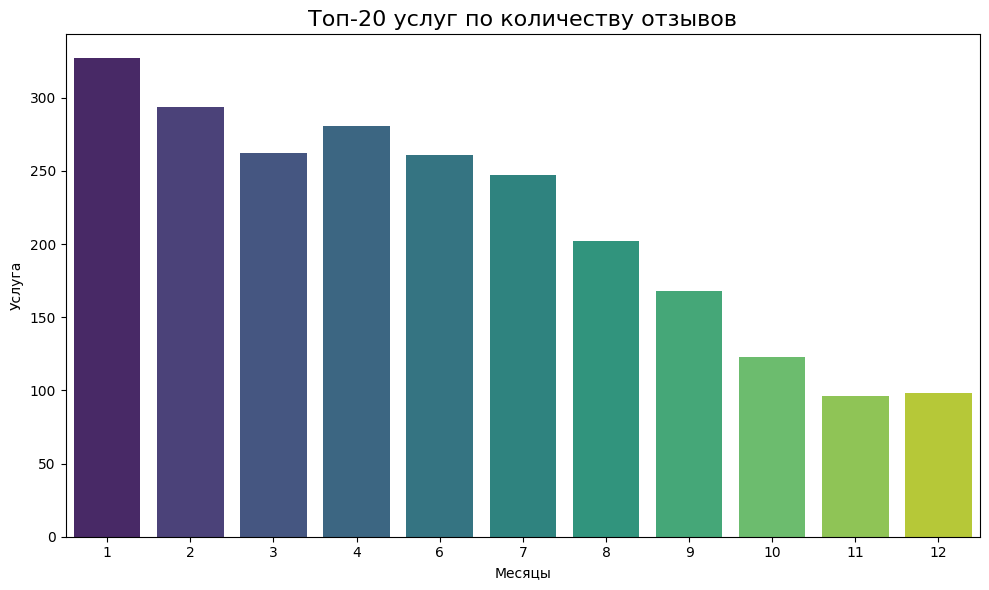

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

top_rate = pd.to_datetime(df['review_date']).dt.month.value_counts()

plt.figure(figsize=(10,6))
ax = sns.barplot(x=top_rate.index, y=top_rate.values, palette="viridis")
plt.title("Топ-20 услуг по количеству отзывов", fontsize=16)
plt.xlabel("Месяцы")
plt.ylabel("Услуга")

plt.tight_layout()
plt.show()


In [ ]:
#кол-во отзывов по услуге
df['service'].value_counts().head(20)

,count
service,
Посещение врача,879
лечении зубов,79
пластической хирургии,64
гинекологии,61
стоматологии,56
травматологии-ортопедии,49
об онкологии,46
об имплантации зубов,43
сосудистой хирургии,42


/tmp/ipython-input-347243916.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_services.values, y=top_services.index, palette="viridis")


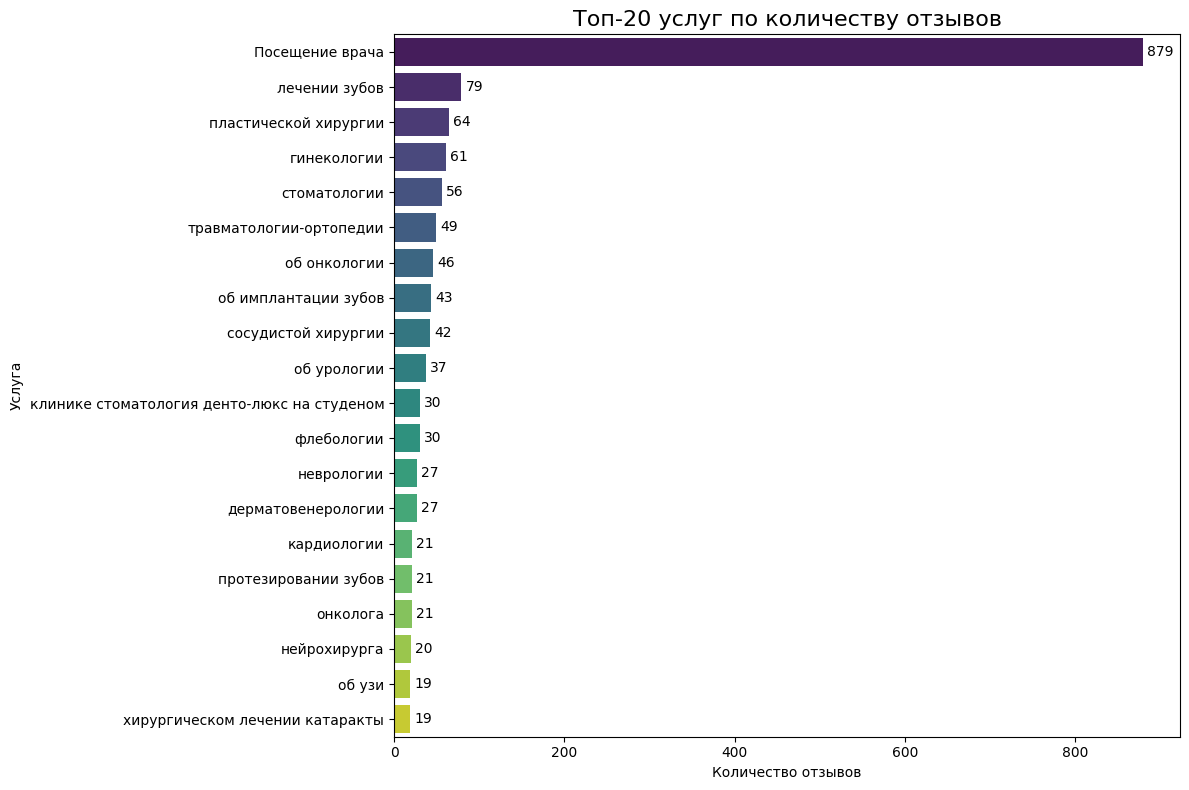

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

top_services = df['service'].value_counts().head(20)

plt.figure(figsize=(12,8))
ax = sns.barplot(x=top_services.values, y=top_services.index, palette="viridis")
plt.title("Топ-20 услуг по количеству отзывов", fontsize=16)
plt.xlabel("Количество отзывов")
plt.ylabel("Услуга")

for i, v in enumerate(top_services.values):
    ax.text(v + 5, i, str(v), color='black', va='center')

plt.tight_layout()
plt.show()


In [ ]:
df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce')

df['month'] = df['review_date'].dt.month

In [ ]:
df.groupby(['month', 'service']).size().unstack(fill_value=0)

service,rf-лифтинге,smas-лифтинге,zoom 4,Посещение врача,акушера-гинеколога,акушера-гинеколога повторный,аллерголога-иммунолога,базовой диагностике зрения с расширением зрачков,биоревитализации,блефаропластике верхних век,...,функциональной диагностике,химическом отбеливании зубов,хирургии,хирургической коррекции носовой перегородки,хирургическом лечении глаукомы,хирургическом лечении катаракты,хирургическом лечении эректильной дисфункции,цельнокерамической коронке,эндокринолога повторный,якорной подтяжке груди
month,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,120,0,2,0,1,1,0,...,0,0,1,1,0,2,0,0,1,1
2,1,0,0,121,0,1,1,0,0,0,...,0,0,1,1,0,2,0,0,3,0
3,0,0,0,92,1,2,0,0,0,0,...,0,0,3,0,0,2,0,0,1,0
4,0,0,0,115,1,0,0,0,0,0,...,0,1,6,0,0,3,0,0,0,0
6,0,0,1,90,2,0,1,0,1,1,...,2,0,0,0,0,1,0,2,0,0
7,0,0,0,88,2,1,0,0,1,2,...,0,0,0,1,0,1,1,0,0,0
8,0,0,0,77,1,1,2,0,0,0,...,0,0,0,0,0,3,0,0,1,0
9,0,0,0,65,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,49,0,0,0,0,0,0,...,0,0,0,2,0,1,0,0,0,1


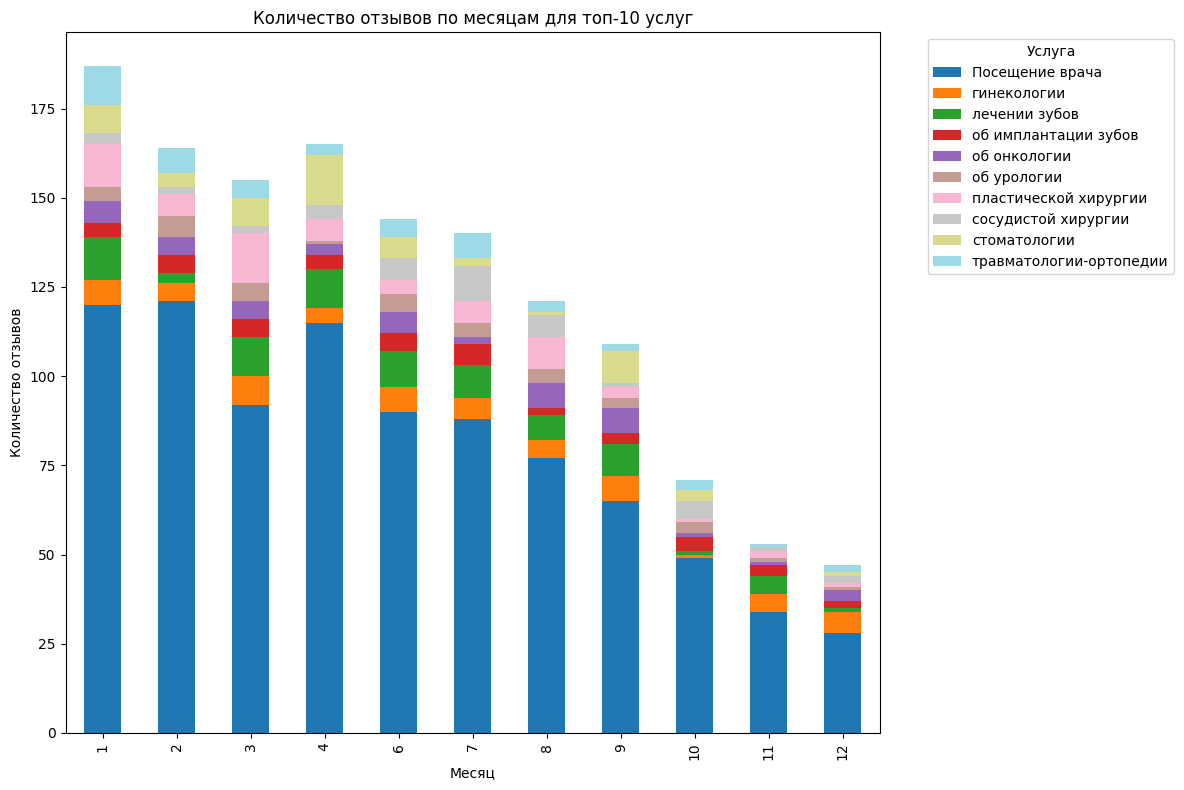

In [ ]:
top_services = df['service'].value_counts().head(10).index
df_top = df[df['service'].isin(top_services)]
monthly_counts = df_top.groupby([df_top['review_date'].dt.month, 'service']).size().unstack(fill_value=0)

monthly_counts.plot(kind='bar', stacked=True, figsize=(12,8), colormap='tab20')
plt.title("Количество отзывов по месяцам для топ-10 услуг")
plt.xlabel("Месяц")
plt.ylabel("Количество отзывов")
plt.legend(title="Услуга", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

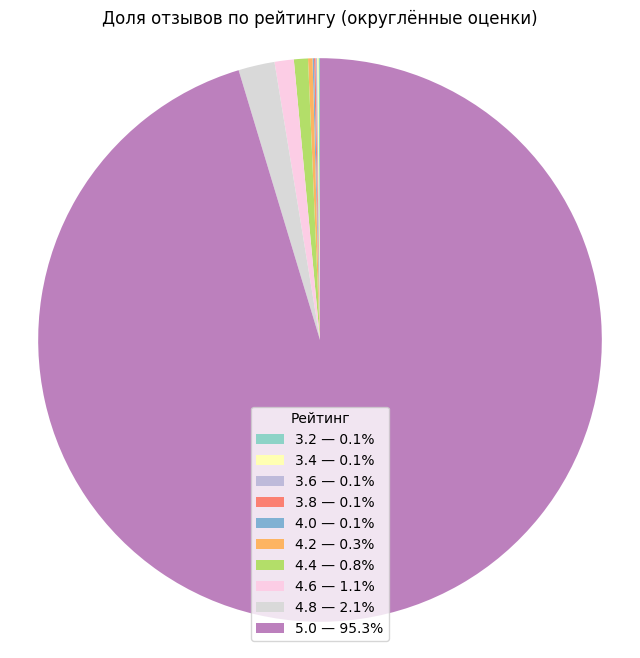

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

rate_counts = df['rate'].value_counts().sort_index()

rate_percent = rate_counts / rate_counts.sum() * 100

plt.figure(figsize=(8,8))
plt.pie(rate_counts.values, labels=None, startangle=90, colors=plt.cm.Set3.colors)

legend_labels = [f"{rate} — {percent:.1f}%" for rate, percent in zip(rate_counts.index, rate_percent)]
plt.legend(legend_labels, title="Рейтинг", loc="best")
plt.title("Доля отзывов по рейтингу (округлённые оценки)")
plt.axis('equal')
plt.show()


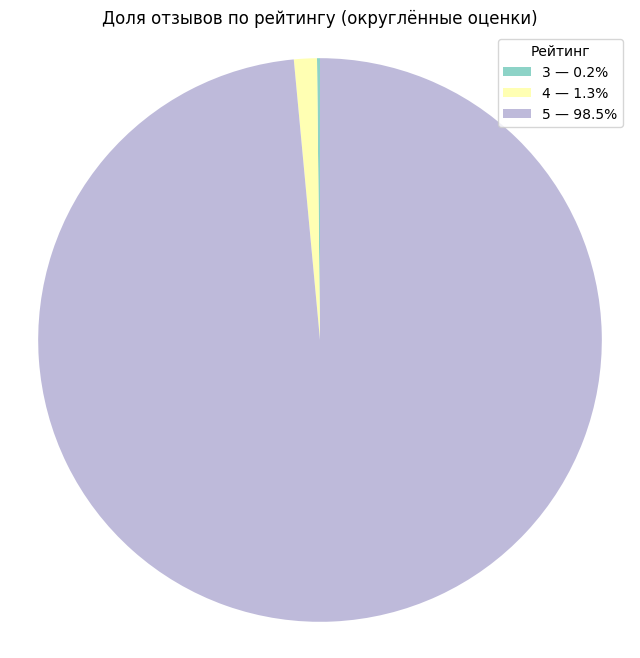

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def custom_round(x):
    decimal = x - int(x)
    if decimal <= 0.5:
        return int(x)
    else:
        return int(x) + 1

df['rate_rounded'] = df['rate'].apply(custom_round)

rate_counts = df['rate_rounded'].value_counts().sort_index()
rate_percent = rate_counts / rate_counts.sum() * 100
plt.figure(figsize=(8,8))
plt.pie(rate_counts.values, labels=None, startangle=90, colors=plt.cm.Set3.colors)
legend_labels = [f"{rate} — {percent:.1f}%" for rate, percent in zip(rate_counts.index, rate_percent)]
plt.legend(legend_labels, title="Рейтинг", loc="best")
plt.title("Доля отзывов по рейтингу (округлённые оценки)")
plt.axis('equal')
plt.show()


работа для моделей


In [ ]:
#X = df.drop(columns=['rate_rounded'])
y = df['rate_rounded']
print("До балансировки:")
print(y.value_counts())
min_class_count = y.value_counts().min()
print("Min class count:", min_class_count)

До балансировки:
rate_rounded
5    2324
4      31
3       4
Name: count, dtype: int64
Min class count: 4


т.к видно ужаснейший дисбаланс классов, было принято решение использовать синтетические данные (по 500 шт) для классов 3 и 4 соответственно. Изначально была выбрана иная стратегия: сначала сгенерировать по 100 примеров, а затем увеличить их кол-во и разнообразие с помощью deep_translator, и применить к сгенерированным предложениям, но позже стало понятно, что значения все равно будут повторяться, поэтому от этой идеи отказалась.

было использовано искуственное ручное добавление отзывов для класса 3 и 4. новый датасет сохранен в переменную df_augmented

In [ ]:
df_augmented

,service,type,stage,date_of_review,rate,text,user,review_date,review_time,rate_rounded
0,Посещение врача,очно,оказана,2025-09-11 16:09:00,5.0,Обращался в клинику для прохождения иглорефлек...,Николаенко Александр,2025-09-11,16:09:00,5
1,дерматовенерологии,очно,оказана,2025-09-11 15:15:00,5.0,Пришла к Алене Вячеславовне в Омниус в полном ...,+7 (993) ***-**-12,2025-09-11,15:15:00,5
2,акушера-гинеколога повторный,очно,оказана,2025-09-11 08:47:00,5.0,"Была на приеме у доктора Ирины Анатольевны, по...",+7 (926) ***-**-47,2025-09-11,08:47:00,5
3,пластической хирургии,очно,оказана,2025-09-10 17:15:00,5.0,"Поехала к хирургу специально, потому что знала...",+7 (901) ***-**-19,2025-09-10,17:15:00,5
4,клинике эксперт зрение,очно,оказана,2025-09-10 12:05:00,5.0,"Достойная клиника, никаких отрицательных момен...",Шмурыгина Дина,2025-09-10,12:05:00,5
...,...,...,...,...,...,...,...,...,...,...
3354,Общая консультация,NaN,NaN,NaT,NaN,"Доктор всё рассказал, но хотелось больше приме...",NaN,NaN,NaN,4
3355,Общая консультация,NaN,NaN,NaT,NaN,"Общее впечатление хорошее, но запись неудобная.",NaN,NaN,NaN,4
3356,Общая консультация,NaN,NaN,NaT,NaN,"Доктор внимательный, консультация хорошая, но ...",NaN,NaN,NaN,4
3357,Общая консультация,NaN,NaN,NaT,NaN,"Место для приёма adequate, но не хватает некот...",NaN,NaN,NaN,4


Обучение

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

X = df_augmented["text"]
y = df_augmented["rate_rounded"]

vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1,2))
X_vec = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42, stratify=y)

Обрабатываем X_train для балансировки

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

rus = RandomUnderSampler(sampling_strategy={5: 500}, random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

ros = RandomOverSampler(sampling_strategy={3: 500, 4: 500, 5: 500}, random_state=42)
X_train_bal, y_train_bal = ros.fit_resample(X_train_rus, y_train_rus)

print("До балансировки:")
print(y_train.value_counts())
print("\nПосле балансировки:")
print(y_train_bal.value_counts())


До балансировки:
rate_rounded
5    1859
4     425
3     403
Name: count, dtype: int64

После балансировки:
rate_rounded
3    500
4    500
5    500
Name: count, dtype: int64


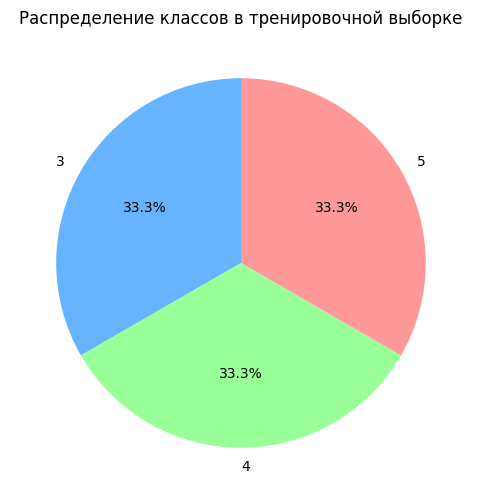

In [ ]:
import matplotlib.pyplot as plt

class_counts = y_train_bal.value_counts()

plt.figure(figsize=(6,6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#99ff99','#ff9999'])
plt.title('Распределение классов в тренировочной выборке')
plt.show()


In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(
    n_estimators=200,
    max_depth=100,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42

),
    "SVM (LinearSVC)": LinearSVC()
}

results = {}
for name, model in models.items():
    print("="*30)
    print(name)
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))

Logistic Regression
Accuracy: 0.9761904761904762
              precision    recall  f1-score   support

           3       0.96      0.93      0.94       101
           4       0.96      0.92      0.94       106
           5       0.98      1.00      0.99       465

    accuracy                           0.98       672
   macro avg       0.97      0.95      0.96       672
weighted avg       0.98      0.98      0.98       672

Naive Bayes
Accuracy: 0.9657738095238095
              precision    recall  f1-score   support

           3       0.94      0.89      0.91       101
           4       0.91      0.92      0.91       106
           5       0.99      0.99      0.99       465

    accuracy                           0.97       672
   macro avg       0.94      0.93      0.94       672
weighted avg       0.97      0.97      0.97       672

Random Forest
Accuracy: 0.9553571428571429
              precision    recall  f1-score   support

           3       0.86      0.89      0.87       

In [ ]:
import time

results = []

for name, model in models.items():
    print("="*30)
    print(name)

    start_train = time.time()
    model.fit(X_train_bal, y_train_bal)
    end_train = time.time()
    train_time = end_train - start_train

    start_test = time.time()
    y_pred = model.predict(X_test)
    end_test = time.time()
    test_time = end_test - start_test

    run_time = train_time + test_time

    acc = accuracy_score(y_test, y_pred)

    results.append({
        "Model": name,
        "Run time (s)": run_time,
        "Training time (s)": train_time,
        "Test time (s)": test_time,
        "Accuracy": acc
    })

df_results = pd.DataFrame(results)
print("\nSummary:")
print(df_results)

Logistic Regression
Naive Bayes
Random Forest
SVM (LinearSVC)

Summary:
                 Model  Run time (s)  Training time (s)  Test time (s)  \
0  Logistic Regression      0.053745           0.053031       0.000714   
1          Naive Bayes      0.011461           0.010858       0.000602   
2        Random Forest      1.353653           1.295910       0.057744   
3      SVM (LinearSVC)      0.018358           0.017643       0.000715   

   Accuracy  
0  0.976190  
1  0.965774  
2  0.955357  
3  0.974702  


проверка на логистической регрессии с помощью ввода отзывов


In [ ]:
def predict_rating_manual(text, model=None, vectorizer=None):
    if model is None or vectorizer is None:
        raise ValueError("Необходимо передать обученную модель и vectorizer")

    X_vec = vectorizer.transform([text])

    pred = model.predict(X_vec)[0]
    return pred

best_model = models["Logistic Regression"]
while True:
    user_text = input("Введите текст отзыва (или 'exit' для выхода): ")
    if user_text.lower() == "exit":
        break

    predicted_rating = predict_rating_manual(user_text, model=best_model, vectorizer=vectorizer)
    print(f"Предсказанная оценка (rate_rounded): {predicted_rating}\n")


Введите текст отзыва (или 'exit' для выхода): Приём прошёл хорошо,  но его объяснения могли бы быть более развёрнутыми
Предсказанная оценка (rate_rounded): 4

Введите текст отзыва (или 'exit' для выхода): Всё очень медленно и печально, персонал не заинтересован в помощи.
Предсказанная оценка (rate_rounded): 3

Введите текст отзыва (или 'exit' для выхода): Отличный сервис! Врач вс очень хорошо объяснил, было очень комфортно и спокойно, Ира Евгеньевна спасибо Вам!
Предсказанная оценка (rate_rounded): 5

Введите текст отзыва (или 'exit' для выхода): exit


In [ ]:
from sklearn.metrics import classification_report, accuracy_score


results = []

for name, model in models.items():
    print("="*30)
    print(name)
    model.fit(X_train_bal, y_train_bal)

    y_train_pred = model.predict(X_train_bal)
    train_acc = accuracy_score(y_train_bal, y_train_pred)

    y_test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)

    results.append({
        "Model": name,
        "Train Accuracy": train_acc,
        "Test Accuracy": test_acc
    })

    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print("\nClassification Report on Test Set:")
    print(classification_report(y_test, y_test_pred))

import pandas as pd
df_results = pd.DataFrame(results)
print("\nSummary of all models:")
print(df_results)


Logistic Regression
Train Accuracy: 0.9720
Test Accuracy: 0.9762

Classification Report on Test Set:
              precision    recall  f1-score   support

           3       0.96      0.93      0.94       101
           4       0.96      0.92      0.94       106
           5       0.98      1.00      0.99       465

    accuracy                           0.98       672
   macro avg       0.97      0.95      0.96       672
weighted avg       0.98      0.98      0.98       672

Naive Bayes
Train Accuracy: 0.9613
Test Accuracy: 0.9658

Classification Report on Test Set:
              precision    recall  f1-score   support

           3       0.94      0.89      0.91       101
           4       0.91      0.92      0.91       106
           5       0.99      0.99      0.99       465

    accuracy                           0.97       672
   macro avg       0.94      0.93      0.94       672
weighted avg       0.97      0.97      0.97       672

Random Forest
Train Accuracy: 0.9293
Test Ac

1. Точность моделей (Accuracy)
Модель	Train Accuracy	Test Accuracy
Logistic Regression	0.972	0.976
Naive Bayes	0.961	0.966
Random Forest	0.929	0.955
SVM (LinearSVC)	0.995	0.975

Выводы:

SVM (LinearSVC) и Logistic Regression показывают высокую точность на тренировочных и тестовых данных, что говорит о том, что модели хорошо обобщают и не переобучаются.

Random Forest стал лучше после исправления параметров, но Train < Test accuracy говорит о том, что деревья видят данные выборочно (bootstrap) и модель немного недообучена.

Naive Bayes уступает немного, но остаётся стабильной и очень быстрой.

2. Разбор по классам
Класс	Logistic Regression	Naive Bayes	Random Forest	SVM
3	0.93	0.89	0.89	0.95
4	0.92	0.92	0.91	0.92
5	1.00	0.99	0.98	0.99

Выводы:

Миноритарные классы (3 и 4):

Лучшие показатели у SVM и Logistic Regression, recall 0.92–0.95.

Random Forest и Naive Bayes немного хуже на классе 3 (recall 0.89), что связано с меньшей способностью этих моделей справляться с дисбалансом или высокой размерностью TF-IDF.

Мажоритарный класс (5): почти все модели предсказывают идеально (recall ~0.98–1.00).

Объяснение:

Миноритарные классы труднее распознавать, так как данных меньше и текстовые особенности могут быть размытыми.

SVM и LR хорошо справляются, так как линейные модели на TF-IDF хорошо различают различия между классами через линейные границы.

3. F1-score

F1-score отражает баланс precision и recall.

Для LR и SVM f1-score ~0.94–0.99 для всех классов — значит модели и точно предсказывают, и почти не пропускают миноритарные классы.

RF немного хуже (0.87–0.98 на классе 3), NB немного уступает.

Объяснение:

У Random Forest слабее f1 для миноритарных классов, потому что деревья “смотрят” только на часть признаков в каждом разбиении (max_features='sqrt') и часть объектов (bootstrap), а при малых классах это снижает точность.

4. Время работы

NB самая быстрая, затем LR и SVM, RF заметно медленнее.

На этих данных время обучения всех моделей небольшое, кроме Random Forest, который требует больше вычислений.

Объяснение:

RF строит сотни деревьев и ищет разбиения по признакам — поэтому время больше.

NB просто считает вероятности по TF-IDF → очень быстро.

LR и SVM решают линейную задачу оптимизации → среднее время.

___________________________________________________________________________
___________________________________________________________________________

ЛАБОРАТОРНАЯ РАБОТА № 2


___________________________________________________________________________
___________________________________________________________________________


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

Сначала обычные алгоритмы на сбалансированных и несбалансированных данных.

Без балансировки


In [ ]:
X_ml_nb = df["text"]
y_ml_nb = df["rate_rounded"]

vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1,2))
X_vec_nb = vectorizer.fit_transform(X_ml_nb)
le = LabelEncoder()
y_enc_nb = le.fit_transform(y_ml_nb)

X_train_ml_nb, X_test_ml_nb, y_train_ml_nb, y_test_ml_nb = train_test_split(X_vec_nb, y_enc_nb, test_size=0.2, random_state=42, stratify=y_enc_nb)

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(
    n_estimators=200,
    max_depth=100,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42

),
    "SVM (LinearSVC)": LinearSVC()
}

results = {}
for name, model in models.items():
    print("="*30)
    print(name)
    model.fit(X_train_ml_nb, y_train_ml_nb)
    y_pred = model.predict(X_test_ml_nb)
    acc = accuracy_score(y_test_ml_nb, y_pred)
    results[name] = acc
    print("Accuracy:", acc)
    print(classification_report(y_test_ml_nb, y_pred))

Logistic Regression
Accuracy: 0.9851694915254238
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         6
           2       0.99      1.00      0.99       465

    accuracy                           0.99       472
   macro avg       0.33      0.33      0.33       472
weighted avg       0.97      0.99      0.98       472

Naive Bayes


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Accuracy: 0.9851694915254238
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         6
           2       0.99      1.00      0.99       465

    accuracy                           0.99       472
   macro avg       0.33      0.33      0.33       472
weighted avg       0.97      0.99      0.98       472

Random Forest
Accuracy: 0.9851694915254238
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         6
           2       0.99      1.00      0.99       465

    accuracy                           0.99       472
   macro avg       0.33      0.33      0.33       472
weighted avg       0.97      0.99      0.98       472

SVM (LinearSVC)
Accuracy: 0.9872881355932204
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Сбалансированные данные

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

X_ml_bal = df_augmented["text"]
y_ml_bal = df_augmented["rate_rounded"]

vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1,2))
X_vec_ml_bal = vectorizer.fit_transform(X_ml_bal)

X_train_ml_bal, X_test_ml_bal, y_train_ml_bal, y_test_ml_bal = train_test_split(X_vec_ml_bal, y_ml_bal, test_size=0.2, random_state=42, stratify=y_ml_bal)


rus = RandomUnderSampler(sampling_strategy={5: 500}, random_state=42)
X_train_rus_ml_bal, y_train_rus_ml_bal = rus.fit_resample(X_train_ml_bal, y_train_ml_bal)

ros = RandomOverSampler(sampling_strategy={3: 500, 4: 500, 5: 500}, random_state=42)
X_train_bal_ml_bal, y_train_bal_ml_bal = ros.fit_resample(X_train_rus_ml_bal, y_train_rus_ml_bal)

print("До балансировки:")
print(y_train_ml_bal.value_counts())
print("\nПосле балансировки:")
print(y_train_bal_ml_bal.value_counts())


До балансировки:
rate_rounded
5    1859
4     425
3     403
Name: count, dtype: int64

После балансировки:
rate_rounded
3    500
4    500
5    500
Name: count, dtype: int64


In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(
    n_estimators=200,
    max_depth=100,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42

),
    "SVM (LinearSVC)": LinearSVC()
}

results = {}
for name, model in models.items():
    print("="*30)
    print(name)
    model.fit(X_train_bal_ml_bal, y_train_bal_ml_bal)
    y_pred = model.predict(X_test_ml_bal)
    acc = accuracy_score(y_test_ml_bal, y_pred)
    results[name] = acc
    print("Accuracy:", acc)
    print(classification_report(y_test_ml_bal, y_pred))

Logistic Regression
Accuracy: 0.9851190476190477
              precision    recall  f1-score   support

           3       0.98      0.97      0.98       101
           4       0.98      0.93      0.96       106
           5       0.99      1.00      0.99       465

    accuracy                           0.99       672
   macro avg       0.98      0.97      0.98       672
weighted avg       0.99      0.99      0.98       672

Naive Bayes
Accuracy: 0.9717261904761905
              precision    recall  f1-score   support

           3       0.93      0.94      0.94       101
           4       0.94      0.92      0.93       106
           5       0.99      0.99      0.99       465

    accuracy                           0.97       672
   macro avg       0.95      0.95      0.95       672
weighted avg       0.97      0.97      0.97       672

Random Forest
Accuracy: 0.9613095238095238
              precision    recall  f1-score   support

           3       0.85      0.95      0.90       

Теперь используем сети

Без баланса

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Epoch 1/10, Train loss: 0.0915, Test loss: 0.0911
Epoch 2/10, Train loss: 0.0907, Test loss: 0.0904
Epoch 3/10, Train loss: 0.0900, Test loss: 0.0898
Epoch 4/10, Train loss: 0.0894, Test loss: 0.0893
Epoch 5/10, Train loss: 0.0889, Test loss: 0.0888
Epoch 6/10, Train loss: 0.0885, Test loss: 0.0884
Epoch 7/10, Train loss: 0.0881, Test loss: 0.0880
Epoch 8/10, Train loss: 0.0877, Test loss: 0.0877
Epoch 9/10, Train loss: 0.0874, Test loss: 0.0874
Epoch 10/10, Train loss: 0.0871, Test loss: 0.0872

Accuracy on test set: 0.9851694915254238

Classification report:

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         6
           5       0.99      1.00      0.99       465

    accuracy                           0.99       472
   macro avg       0.33      0.33      0.33       472
weighted avg       0.97      0.99      0.98       472



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


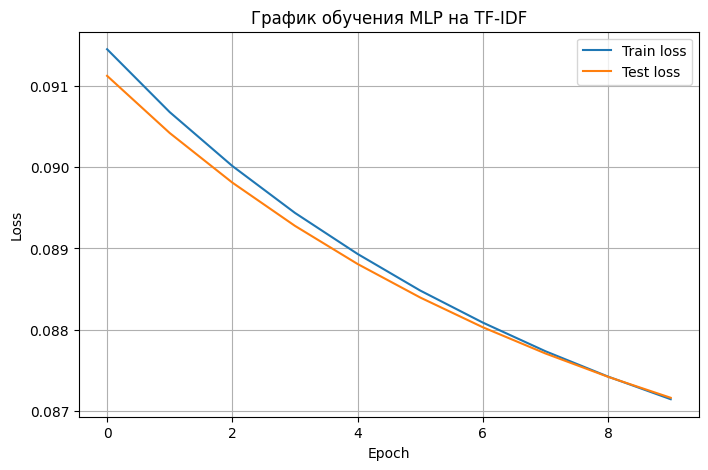

In [ ]:
import matplotlib.pyplot as plt

train_losses = []
test_losses = []

for epoch in range(epochs):
    permutation = np.random.permutation(X_train_nb.shape[0])
    X_shuffled = X_train_nb[permutation]
    y_shuffled = y_train_nb[permutation]

    epoch_loss = 0
    for i in range(0, X_shuffled.shape[0], batch_size):
        X_batch = X_shuffled[i:i+batch_size].toarray()
        y_batch = y_shuffled[i:i+batch_size]

        # --- Forward pass ---
        Z1 = np.dot(X_batch, W1) + b1
        A1 = relu(Z1)

        Z2 = np.dot(A1, W2) + b2
        A2 = relu(Z2)

        Z3 = np.dot(A2, W3) + b3
        A3 = softmax(Z3)

        loss = cross_entropy_loss(y_batch, A3)
        epoch_loss += loss * X_batch.shape[0]

        # --- Backward pass ---
        n = X_batch.shape[0]
        dZ3 = A3.copy()
        dZ3[range(n), y_batch] -= 1
        dZ3 /= n

        dW3 = np.dot(A2.T, dZ3)
        db3 = np.sum(dZ3, axis=0, keepdims=True)

        dA2 = np.dot(dZ3, W3.T)
        dZ2 = dA2 * relu_derivative(Z2)
        dW2 = np.dot(A1.T, dZ2)
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        dA1 = np.dot(dZ2, W2.T)
        dZ1 = dA1 * relu_derivative(Z1)
        dW1 = np.dot(X_batch.T, dZ1)
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        # --- Обновление весов ---
        W3 -= learning_rate * dW3
        b3 -= learning_rate * db3
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1


    avg_train_loss = epoch_loss / X_train_nb.shape[0]
    train_losses.append(avg_train_loss)

    # -----------------------------
    # Test loss
    # -----------------------------
    X_test_dense = X_test_nb.toarray()
    Z1_test = np.dot(X_test_dense, W1) + b1
    A1_test = relu(Z1_test)

    Z2_test = np.dot(A1_test, W2) + b2
    A2_test = relu(Z2_test)

    Z3_test = np.dot(A2_test, W3) + b3
    A3_test = softmax(Z3_test)

    test_loss = cross_entropy_loss(y_test_nb, A3_test)
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Test loss: {test_loss:.4f}")


accuracy = accuracy_score(y_test_nb, y_pred_test)
print("\nAccuracy on test set:", accuracy)
print("\nClassification report:\n")
print(classification_report(y_test_nb, y_pred_test, target_names=[str(c) for c in le.classes_]))


plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("График обучения MLP на TF-IDF")
plt.legend()
plt.grid(True)
plt.show()


С балансированными

Epoch 1/10, Train loss: 1.0960, Test loss: 1.0761
Epoch 2/10, Train loss: 1.0892, Test loss: 1.0504
Epoch 3/10, Train loss: 1.0803, Test loss: 1.0154
Epoch 4/10, Train loss: 1.0675, Test loss: 0.9674
Epoch 5/10, Train loss: 1.0499, Test loss: 0.9109
Epoch 6/10, Train loss: 1.0265, Test loss: 0.8491
Epoch 7/10, Train loss: 0.9958, Test loss: 0.7807
Epoch 8/10, Train loss: 0.9561, Test loss: 0.7070
Epoch 9/10, Train loss: 0.9067, Test loss: 0.6434
Epoch 10/10, Train loss: 0.8484, Test loss: 0.5828

Accuracy on test set: 0.8647430117222723

Classification report:

              precision    recall  f1-score   support

           3       0.75      0.60      0.67       167
           4       0.83      0.52      0.64       175
           5       0.89      1.00      0.94       767

    accuracy                           0.86      1109
   macro avg       0.82      0.71      0.75      1109
weighted avg       0.86      0.86      0.85      1109



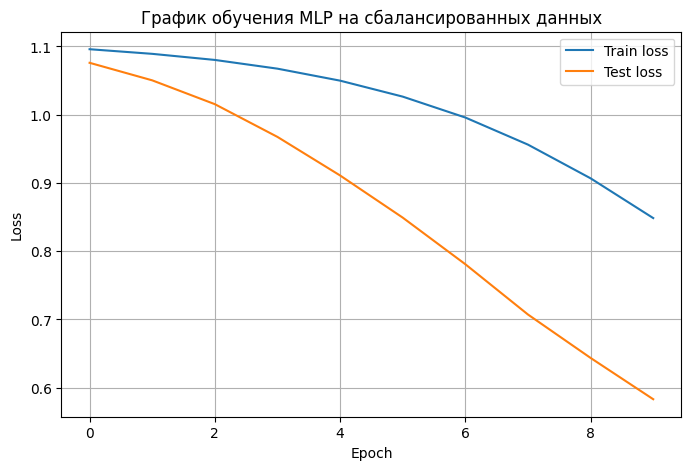

Примеры предсказаний:
Отзыв: Дважды была на приеме у Шемчук Аллы Васильевны. Ос... => Предсказанный рейтинг: 5
Отзыв: Советы хорошие, но хотелось больше информации.... => Предсказанный рейтинг: 4
Отзыв: Консультация не оправдала ожиданий, персонал выгля... => Предсказанный рейтинг: 3
Отзыв: Врач принял качественно, но ожидание чуть испортил... => Предсказанный рейтинг: 4
Отзыв: Доктор огласил диагноз, но не объяснил, что он зна... => Предсказанный рейтинг: 5


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from nltk.corpus import stopwords


russian_stopwords = stopwords.words("russian")

X = df_augmented["text"]
y = df_augmented["rate_rounded"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.33, random_state=42, stratify=y_encoded
)

# Балансировка классов
rus = RandomUnderSampler(sampling_strategy={2: 500}, random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train.to_frame(), y_train)

ros = RandomOverSampler(sampling_strategy={0: 500, 1: 500, 2: 500}, random_state=42)
X_train_bal, y_train_bal = ros.fit_resample(X_train_rus, y_train_rus)

# TF-IDF
vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1,2), stop_words=russian_stopwords)
X_train_tfidf = vectorizer.fit_transform(X_train_bal["text"]).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

# Стандартизация для ускорения сходимости
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_tfidf)
X_test_scaled = scaler.transform(X_test_tfidf)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    n_samples = y_true.shape[0]
    clipped = np.clip(y_pred, 1e-12, 1.0)
    log_likelihood = -np.log(clipped[range(n_samples), y_true])
    return np.sum(log_likelihood) / n_samples

# -----------------------------
# Инициализация весов
# -----------------------------
input_size = X_train_scaled.shape[1]
hidden1 = 512
hidden2 = 256
output_size = len(np.unique(y_train_bal))

np.random.seed(42)
W1 = np.random.randn(input_size, hidden1) * 0.01
b1 = np.zeros((1, hidden1))
W2 = np.random.randn(hidden1, hidden2) * 0.01
b2 = np.zeros((1, hidden2))
W3 = np.random.randn(hidden2, output_size) * 0.01
b3 = np.zeros((1, output_size))

learning_rate = 0.01
epochs = 10
batch_size = 32

# -----------------------------
# Обучение сети + логирование
# -----------------------------
train_losses = []
test_losses = []

for epoch in range(epochs):
    permutation = np.random.permutation(X_train_scaled.shape[0])
    X_shuffled = X_train_scaled[permutation]
    y_shuffled = y_train_bal[permutation]

    epoch_loss = 0
    for i in range(0, X_shuffled.shape[0], batch_size):
        X_batch = X_shuffled[i:i+batch_size]
        y_batch = y_shuffled[i:i+batch_size]

        # --- Forward pass ---
        Z1 = np.dot(X_batch, W1) + b1
        A1 = relu(Z1)

        Z2 = np.dot(A1, W2) + b2
        A2 = relu(Z2)

        Z3 = np.dot(A2, W3) + b3
        A3 = softmax(Z3)

        loss = cross_entropy_loss(y_batch, A3)
        epoch_loss += loss * X_batch.shape[0]

        # --- Backward pass ---
        n = X_batch.shape[0]
        dZ3 = A3.copy()
        dZ3[range(n), y_batch] -= 1
        dZ3 /= n

        dW3 = np.dot(A2.T, dZ3)
        db3 = np.sum(dZ3, axis=0, keepdims=True)

        dA2 = np.dot(dZ3, W3.T)
        dZ2 = dA2 * relu_derivative(Z2)
        dW2 = np.dot(A1.T, dZ2)
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        dA1 = np.dot(dZ2, W2.T)
        dZ1 = dA1 * relu_derivative(Z1)
        dW1 = np.dot(X_batch.T, dZ1)
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        # --- Обновление весов ---
        W3 -= learning_rate * dW3
        b3 -= learning_rate * db3
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1

    # Train loss
    avg_train_loss = epoch_loss / X_train_scaled.shape[0]
    train_losses.append(avg_train_loss)

    # Test loss
    Z1_test = np.dot(X_test_scaled, W1) + b1
    A1_test = relu(Z1_test)

    Z2_test = np.dot(A1_test, W2) + b2
    A2_test = relu(Z2_test)

    Z3_test = np.dot(A2_test, W3) + b3
    A3_test = softmax(Z3_test)

    test_loss = cross_entropy_loss(y_test, A3_test)
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Test loss: {test_loss:.4f}")

# -----------------------------
# Метрики
# -----------------------------
y_pred_test = np.argmax(A3_test, axis=1)
y_pred_ratings = le.inverse_transform(y_pred_test)

accuracy = accuracy_score(y_test, y_pred_test)
print("\nAccuracy on test set:", accuracy)
print("\nClassification report:\n")
print(classification_report(y_test, y_pred_test, target_names=[str(c) for c in le.classes_]))

# -----------------------------
# График обучения
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("График обучения MLP на сбалансированных данных")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# Примеры предсказаний
# -----------------------------
import random
random_idx = random.sample(range(len(X_test)), 5)

print("Примеры предсказаний:")
for idx in random_idx:
    text = X_test.iloc[idx]
    pred = y_pred_ratings[idx]
    print(f"Отзыв: {text[:50]}... => Предсказанный рейтинг: {pred}")


RNN

Epoch 1/5, Loss: 0.1599
Epoch 2/5, Loss: 0.0865
Epoch 3/5, Loss: 0.0825
Epoch 4/5, Loss: 0.0821
Epoch 5/5, Loss: 0.0838

Accuracy on test set: 0.9859
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        10
           5       0.99      1.00      0.99       768

    accuracy                           0.99       779
   macro avg       0.33      0.33      0.33       779
weighted avg       0.97      0.99      0.98       779



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/5, Train loss: 0.0796, Test loss: 0.0745
Epoch 2/5, Train loss: 0.0801, Test loss: 0.0719
Epoch 3/5, Train loss: 0.0770, Test loss: 0.0706
Epoch 4/5, Train loss: 0.0773, Test loss: 0.0713
Epoch 5/5, Train loss: 0.0759, Test loss: 0.0737

Accuracy on test set: 0.9872
              precision    recall  f1-score   support

           3       1.00      1.00      1.00         1
           4       0.00      0.00      0.00        10
           5       0.99      1.00      0.99       768

    accuracy                           0.99       779
   macro avg       0.66      0.67      0.66       779
weighted avg       0.97      0.99      0.98       779



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


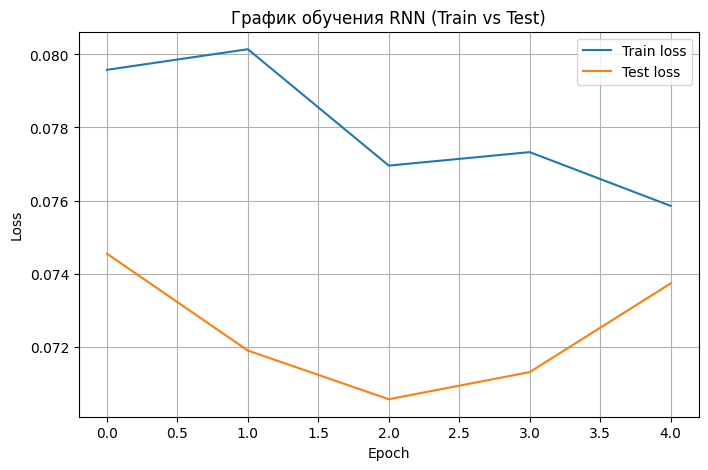

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import numpy as np

X = df["text"]
y = df["rate_rounded"]

le = LabelEncoder()
y_enc = le.fit_transform(y)  # метки 0,1,2 (если 3,4,5)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.33, random_state=42, stratify=y_enc
)

MAX_WORDS = 5000   # максимальный размер словаря
MAX_LEN = 100      # максимальная длина последовательности

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

X_train_tensor = torch.tensor(X_train_pad, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_pad, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        _, h_n = self.rnn(x)
        return self.fc(h_n.squeeze(0))

model = RNN(vocab_size=MAX_WORDS, embed_dim=64, hidden_dim=128, num_classes=len(le.classes_))


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 5
train_losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * X_batch.size(0)

    avg_loss = epoch_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")


model.eval()
with torch.no_grad():
    output_test = model(X_test_tensor)
    y_pred = torch.argmax(output_test, dim=1)

accuracy = (y_pred == y_test_tensor).float().mean()
print(f"\nAccuracy on test set: {accuracy:.4f}")

from sklearn.metrics import classification_report
print(classification_report(y_test_tensor, y_pred, target_names=[str(c) for c in le.classes_]))


epochs = 5
train_losses = []
test_losses = []

for epoch in range(epochs):
    # --- Train ---
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * X_batch.size(0)
    avg_train_loss = epoch_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # --- Test ---
    model.eval()
    with torch.no_grad():
        output_test = model(X_test_tensor)
        test_loss = criterion(output_test, y_test_tensor).item()
        test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Test loss: {test_loss:.4f}")


y_pred = torch.argmax(output_test, dim=1)
accuracy = (y_pred == y_test_tensor).float().mean()
print(f"\nAccuracy on test set: {accuracy:.4f}")
from sklearn.metrics import classification_report
print(classification_report(y_test_tensor, y_pred, target_names=[str(c) for c in le.classes_]))

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("График обучения RNN (Train vs Test)")
plt.legend()
plt.grid(True)
plt.show()


Балансированные

Epoch 1/5, Train loss: 1.1099, Test loss: 1.1272
Epoch 2/5, Train loss: 1.1014, Test loss: 1.1843
Epoch 3/5, Train loss: 1.0910, Test loss: 1.2301
Epoch 4/5, Train loss: 1.0903, Test loss: 1.1987
Epoch 5/5, Train loss: 1.0737, Test loss: 1.0614

Accuracy on test set: 0.6456
              precision    recall  f1-score   support

           3       0.08      0.01      0.01       167
           4       0.02      0.01      0.01       175
           5       0.68      0.93      0.78       767

    accuracy                           0.65      1109
   macro avg       0.26      0.31      0.27      1109
weighted avg       0.48      0.65      0.55      1109



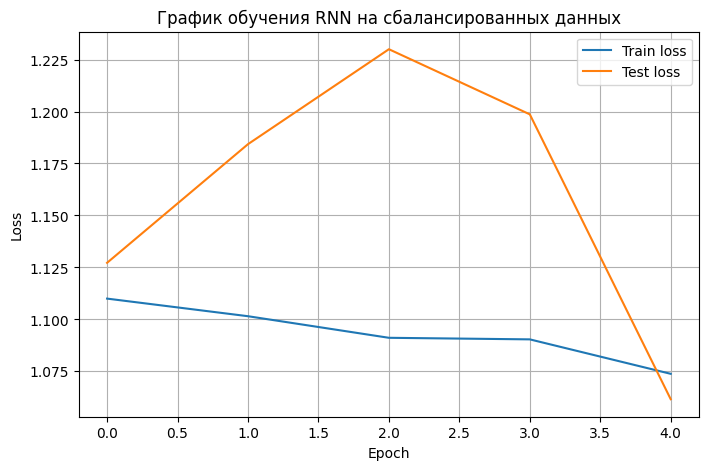

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import numpy as np


X = df_augmented["text"]
y = df_augmented["rate_rounded"]

le = LabelEncoder()
y_enc = le.fit_transform(y)


X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.33, random_state=42, stratify=y_enc
)

rus = RandomUnderSampler(sampling_strategy={2: 500}, random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train.to_frame(), y_train)

ros = RandomOverSampler(sampling_strategy={0: 500, 1: 500, 2: 500}, random_state=42)
X_train_bal, y_train_bal = ros.fit_resample(X_train_rus, y_train_rus)


MAX_WORDS = 5000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_bal["text"])

X_train_seq = tokenizer.texts_to_sequences(X_train_bal["text"])
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

X_train_tensor = torch.tensor(X_train_pad, dtype=torch.long)
y_train_tensor = torch.tensor(y_train_bal, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_pad, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        _, h_n = self.rnn(x)
        return self.fc(h_n.squeeze(0))

model = RNN(vocab_size=MAX_WORDS, embed_dim=64, hidden_dim=128, num_classes=len(le.classes_))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


epochs = 5
train_losses = []
test_losses = []

for epoch in range(epochs):
    # --- Train ---
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * X_batch.size(0)
    avg_train_loss = epoch_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # --- Test ---
    model.eval()
    with torch.no_grad():
        output_test = model(X_test_tensor)
        test_loss = criterion(output_test, y_test_tensor).item()
        test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Test loss: {test_loss:.4f}")


y_pred = torch.argmax(output_test, dim=1)
accuracy = (y_pred == y_test_tensor).float().mean()
print(f"\nAccuracy on test set: {accuracy:.4f}")

from sklearn.metrics import classification_report
print(classification_report(y_test_tensor, y_pred, target_names=[str(c) for c in le.classes_]))


plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("График обучения RNN на сбалансированных данных")
plt.legend()
plt.grid(True)
plt.show()


LSTM

Несбалансированные

Epoch 1/5, Train loss: 0.1901, Test loss: 0.0820
Epoch 2/5, Train loss: 0.0856, Test loss: 0.0784
Epoch 3/5, Train loss: 0.0844, Test loss: 0.0781
Epoch 4/5, Train loss: 0.0840, Test loss: 0.0778
Epoch 5/5, Train loss: 0.0862, Test loss: 0.0776

Accuracy on test set: 0.9859
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        10
           5       0.99      1.00      0.99       768

    accuracy                           0.99       779
   macro avg       0.33      0.33      0.33       779
weighted avg       0.97      0.99      0.98       779



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


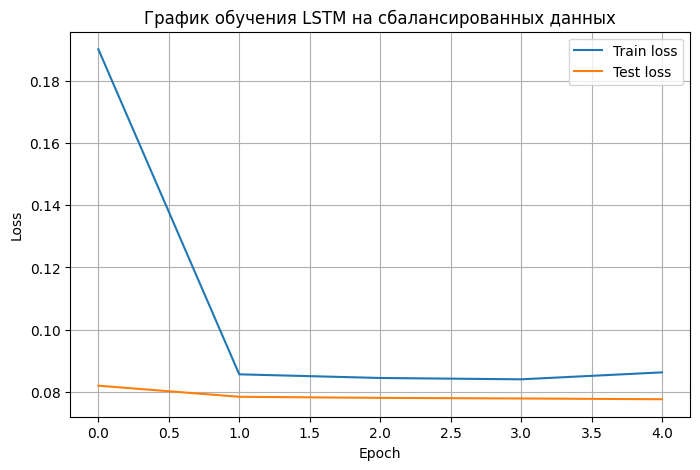

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt


X = df["text"]
y = df["rate_rounded"]

le = LabelEncoder()
y_enc = le.fit_transform(y)


X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.33, random_state=42, stratify=y_enc
)


MAX_WORDS = 5000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

# Тензоры
X_train_tensor = torch.tensor(X_train_pad, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_pad, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        return self.fc(h_n.squeeze(0))

model = LSTMModel(vocab_size=MAX_WORDS, embed_dim=64, hidden_dim=128, num_classes=len(le.classes_))


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


epochs = 5
train_losses = []
test_losses = []

for epoch in range(epochs):
    # --- Train ---
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * X_batch.size(0)
    avg_train_loss = epoch_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # --- Test ---
    model.eval()
    with torch.no_grad():
        output_test = model(X_test_tensor)
        test_loss = criterion(output_test, y_test_tensor).item()
        test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Test loss: {test_loss:.4f}")


y_pred = torch.argmax(output_test, dim=1)
accuracy = (y_pred == y_test_tensor).float().mean()
print(f"\nAccuracy on test set: {accuracy:.4f}")

from sklearn.metrics import classification_report
print(classification_report(y_test_tensor, y_pred, target_names=[str(c) for c in le.classes_]))


plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("График обучения LSTM на несбалансированных данных")
plt.legend()
plt.grid(True)
plt.show()


Балансированные

Epoch 1/5, Train loss: 1.0998, Test loss: 1.1092
Epoch 2/5, Train loss: 1.1159, Test loss: 1.1868
Epoch 3/5, Train loss: 1.0843, Test loss: 1.1323
Epoch 4/5, Train loss: 0.9609, Test loss: 0.4811
Epoch 5/5, Train loss: 0.6019, Test loss: 0.3118

Accuracy on test set: 0.8296
              precision    recall  f1-score   support

           3       0.48      0.83      0.61       167
           4       0.43      0.09      0.14       175
           5       0.97      1.00      0.99       767

    accuracy                           0.83      1109
   macro avg       0.63      0.64      0.58      1109
weighted avg       0.81      0.83      0.80      1109



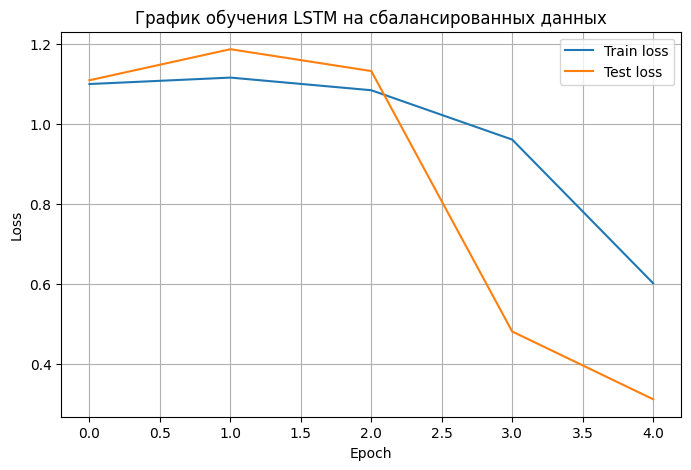

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

X = df_augmented["text"]
y = df_augmented["rate_rounded"]

le = LabelEncoder()
y_enc = le.fit_transform(y)


X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.33, random_state=42, stratify=y_enc
)


rus = RandomUnderSampler(sampling_strategy={2: 500}, random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train.to_frame(), y_train)

ros = RandomOverSampler(sampling_strategy={0: 500, 1: 500, 2: 500}, random_state=42)
X_train_bal, y_train_bal = ros.fit_resample(X_train_rus, y_train_rus)


MAX_WORDS = 5000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_bal["text"])

X_train_seq = tokenizer.texts_to_sequences(X_train_bal["text"])
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

X_train_tensor = torch.tensor(X_train_pad, dtype=torch.long)
y_train_tensor = torch.tensor(y_train_bal, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_pad, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        return self.fc(h_n.squeeze(0))

model = LSTMModel(vocab_size=MAX_WORDS, embed_dim=64, hidden_dim=128, num_classes=len(le.classes_))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 5
train_losses = []
test_losses = []

for epoch in range(epochs):
    # --- Train ---
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * X_batch.size(0)
    avg_train_loss = epoch_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # --- Test ---
    model.eval()
    with torch.no_grad():
        output_test = model(X_test_tensor)
        test_loss = criterion(output_test, y_test_tensor).item()
        test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Test loss: {test_loss:.4f}")

y_pred = torch.argmax(output_test, dim=1)
accuracy = (y_pred == y_test_tensor).float().mean()
print(f"\nAccuracy on test set: {accuracy:.4f}")

from sklearn.metrics import classification_report
print(classification_report(y_test_tensor, y_pred, target_names=[str(c) for c in le.classes_]))


plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("График обучения LSTM на сбалансированных данных")
plt.legend()
plt.grid(True)
plt.show()


**Logistic Regression**

Без балансировки: модель полностью игнорирует редкие классы (оценки 3 и 4) и всегда предсказывает только самый частый — 5. Итоговая точность кажется высокой, но на деле модель бесполезна.

С балансировкой: одна из лучших моделей. Уверенно различает все три класса, работает стабильно и обучается быстро. Особенно хорошо справляется с текстовыми признаками (TF-IDF).

**Naive Bayes**

Без балансировки: поведение такое же, как у остальных моделей — фокус только на классе 5.

С балансировкой: результаты хорошие, но немного слабее, чем у логистической регрессии. Модель надёжная и очень быстрая, однако хуже работает с редкими классами.

**Random Forest**

Без балансировки: снова только класс 5, сложность модели ничего не меняет.

С балансировкой: даёт приемлемое качество, но всё же хуже линейных моделей. Из-за особенностей работы с TF-IDF и бутстраппинга плохо улавливает редкие текстовые паттерны.

SVM (LinearSVC)

Без балансировки: почти всегда предсказывает 5, другие классы угадывает случайно.

С балансировкой: результат сопоставим с Logistic Regression. Модель точно различает классы и остаётся стабильной. Хороший выбор, если важна надёжность.

MLP (нейросеть на TF-IDF)

Без балансировки: как и другие модели, обучается только на мажоритарном классе.

С балансировкой: уступает линейным моделям. Несмотря на корректное обучение, не даёт преимуществ и не оправдывает свою сложность.

RNN

Без балансировки: редкие оценки полностью игнорируются.

С балансировкой: результат слабый. Простая архитектура не справляется с задачей даже при равномерных данных и не улавливает семантические различия между классами.

LSTM

Без балансировки: картина та же, что и у RNN — предсказания только по классу 5.

С балансировкой: работает лучше RNN, но всё равно заметно уступает линейным моделям. Особенно плохо справляется с одним из редких классов (обычно с оценкой 4), что говорит о проблемах с обобщением или качеством синтетических данных.